In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [3]:
dataset_path = "DetectionDataset\dataset"  # root folder where images are stored
categories = os.listdir(dataset_path)

print("Categories:", categories)


Categories: ['benign', 'malware']


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18548\1576015304.py:1: SyntaxWarning: invalid escape sequence '\d'
  dataset_path = "DetectionDataset\dataset"  # root folder where images are stored


In [4]:
IMG_SIZE = 128   # resize images
data = []
labels = []

for category in categories:
    folder = os.path.join(dataset_path, category)
    label = categories.index(category)

    for file in os.listdir(folder):
        try:
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except:
            continue

data = np.array(data) / 255.0   # normalize
labels = np.array(labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (5386, 128, 128, 3)
Labels shape: (5386,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (4308, 128, 128, 3) Test set: (1078, 128, 128, 3)


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [7]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_test, y_test),
    verbose=1
)


c:\Users\ASUS\Downloads\trojan_image\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 114s 753ms/step - accuracy: 0.5046 - loss: 0.7764 - val_accuracy: 0.5380 - val_loss: 0.6793
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 607ms/step - accuracy: 0.5418 - loss: 0.7177 - val_accuracy: 0.6744 - val_loss: 0.6708
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 592ms/step - accuracy: 0.5492 - loss: 0.7004 - val_accuracy: 0.5918 - val_loss: 0.6609
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - accuracy: 0.5557 - loss: 0.6853 - val_accuracy: 0.6874 - val_loss: 0.6543
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 598ms/step - accuracy: 0.6024 - loss: 0.6645 - val_accuracy: 0.6577 - val_loss: 0.6457
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 595ms/step - accuracy: 0.6119 - loss: 0.6572 - val_accuracy: 0.6920 - val_loss: 0.6379
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 614ms/step - accuracy: 0.6430 - loss: 0.6454 - val_accuracy: 0.6957 - val_loss: 0.6313
Epoch 8/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 603ms/step - accuracy: 0.6562 - loss: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 555ms/step
              precision    recall  f1-score   support

      benign       0.70      0.64      0.67       492
     malware       0.72      0.77      0.74       586

    accuracy                           0.71      1078
   macro avg       0.71      0.70      0.70      1078
weighted avg       0.71      0.71      0.71      1078



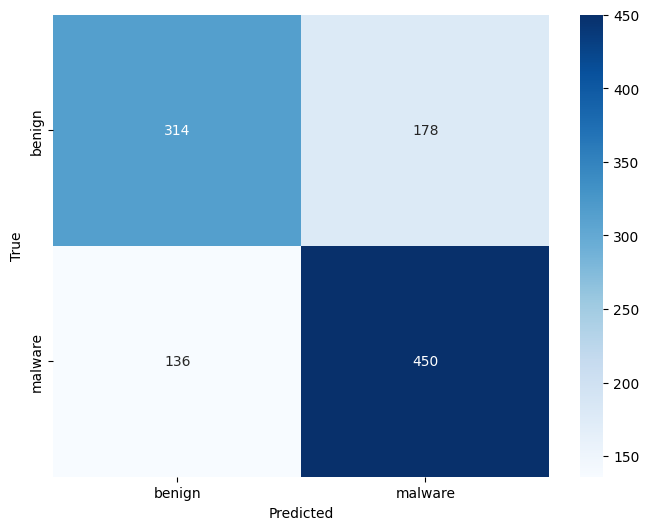

In [9]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [10]:
model.save("malware_detection_resnet50.h5")
print("Model saved!")


Model saved!
